# Benchmark Modell 2 with SPS

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('../..')
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from statsmodels.regression.linear_model import WLS

pd.options.display.max_columns = None

In [25]:
data = pd.read_table('../../data/data_sps.txt', sep=' ')
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
feature_cols.remove('start_time')

In [26]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
X,y = data[feature_cols], data['size_mm']
X.head(2)

,packnr,velocity,centroid_frequency_G01,centroid_frequency2_G01,centroid_frequency_G02,centroid_frequency2_G02,centroid_frequency_M01,centroid_frequency2_M01,centroid_frequency_S01,centroid_frequency2_S01,median_freq_G01,median_freq_G02,median_freq_M01,median_freq_S01,flash_ind_G01,flash_ind_G02,flash_ind_M01,flash_ind_S01,cv_G01,cv_G02,cv_M01,cv_S01,iqa_G01,iqa_G02,iqa_M01,iqa_S01,mab_G01,mab_G02,mab_M01,mab_S01,imp_G01,imp_G02,imp_M01,imp_S01,len_G01,len_G02,len_M01,len_S01
0,15,3.2,5424.572186,1520.781662,4013.797724,2931.354363,8652.790926,7182.425705,8379.295548,6547.882196,3485.455767,3055.208472,7244.649105,6737.795587,0.007034,0.006666,0.005020,0.006973,1.766690,1.600798,1.271133,0.985044,4.766670e-10,3.898390e-09,0.000039,0.028844,0.001161,0.004824,0.579816,10,0,0,0,0,74,74,74,74
1,128,2.5,2531.546238,2452.230598,2513.989739,2317.553615,5611.165495,5714.516900,4529.183358,3008.921229,2479.874016,2356.206594,5636.518996,3020.389124,0.011831,0.007217,0.008924,0.024140,3.013262,2.634793,1.690594,2.014689,3.733215e-04,1.154980e-03,1.444022,1681.905351,0.903171,2.099359,68.647197,1359,12,9,25,17,298,298,298,298


In [27]:
data.shape

(11254, 40)

## Select Best Feature for Benchmark

In [3]:
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector

In [5]:
best_feature_dict = {}
best_feature_cvscores = {}
for n_features in tqdm(np.arange(1,10+1)):
    select = SequentialFeatureSelector(estimator=LinearRegression(), 
                                       n_features_to_select=n_features, 
                                       direction='forward', 
                                       scoring='r2')
    select.fit(X, np.log(y))
    best_col = X.columns.to_numpy()[select.get_support()]
    best_feature_dict[n_features] = best_col
    best_feature_cvscores[n_features] = cross_val_score(estimator=LinearRegression(),
                                                        X=X[best_col], 
                                                        y=np.log(y), cv=10, 
                                                        scoring='r2')

100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


In [6]:
tmp = pd.melt(pd.DataFrame.from_dict(best_feature_cvscores), var_name='n_feature', value_name='score')
tmp['score'] = np.abs(tmp['score'])
tmp.head(2)

,n_feature,score
0,1,0.647607
1,1,0.678038


In [7]:
tmp_ = tmp.groupby('n_feature').mean()

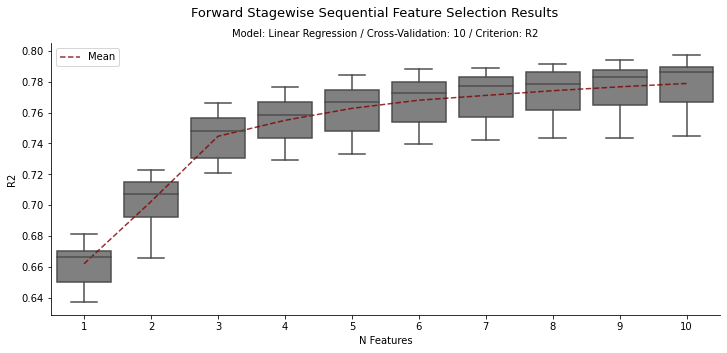

In [8]:
fig = plt.subplots(figsize=(12, 5))
p = sns.boxplot(x=tmp['n_feature'], y=tmp['score'], color='grey')
p1 = sns.lineplot(x=tmp_.index-1, y=tmp_.to_numpy().reshape(-1), color='maroon', 
                  linestyle='--', label='Mean', alpha=.8)
plt.title(r'Model: Linear Regression / Cross-Validation: 10 / Criterion: R2', fontsize=10)
plt.suptitle('Forward Stagewise Sequential Feature Selection Results', fontsize=13)
plt.xlabel('N Features')
plt.ylabel(r'R2')
sns.despine()
plt.show()

In [9]:
n_features = 3
best_feature_dict[n_features]

array(['centroid_frequency2_M01', 'centroid_frequency_S01', 'imp_M01'],
      dtype=object)

In [10]:
X_best = X[best_feature_dict[n_features]]

## Hyperparameter 

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
results = cross_val_score(estimator=LinearRegression(), X=X_best, y=np.log(y), cv=10)
print('CV Results:\n', results)
print('Mean Resutls: ', np.mean(results))

NameError: name 'X_best' is not defined

## With Max-Feature

In [28]:
from helper.feature_extract import extract_highest_amplitude_features_with_mp

In [29]:
df_max = extract_highest_amplitude_features_with_mp(df=data, sensor_types=[['G01', 'G02'], ['M01'], ['S01']],
                                                  create_one_sensor_feature=True, n_processes=4, 
                                                  keep_columns=False)

INFO || Extracting Max Features for types: ['G01', 'G02']
INFO || Extracting Max Features for types: ['M01']
INFO || Extracting Max Features for types: ['S01']


In [30]:
feature_cols = df_max.columns.to_list()
feature_cols.remove('size_mm')
feature_cols.remove('start_time')

In [31]:
X,y = df_max[feature_cols], df_max['size_mm']
X.head(2)

,packnr,velocity,max_centroid_frequency_G,max_centroid_frequency2_G,max_median_freq_G,max_flash_ind_G,max_cv_G,max_iqa_G,max_mab_G,max_imp_G,max_len_G,max_centroid_frequency_M,max_centroid_frequency2_M,max_median_freq_M,max_flash_ind_M,max_cv_M,max_iqa_M,max_mab_M,max_imp_M,max_len_M,max_centroid_frequency_S,max_centroid_frequency2_S,max_median_freq_S,max_flash_ind_S,max_cv_S,max_iqa_S,max_mab_S,max_imp_S,max_len_S
0,15,3.2,4013.797724,2931.354363,3055.208472,0.006666,1.600798,3.898390e-09,0.004824,0,74,8652.790926,7182.425705,7244.649105,0.005020,1.271133,0.000039,0.579816,0,74,8379.295548,6547.882196,6737.795587,0.006973,0.985044,0.028844,10,0,74
1,128,2.5,2513.989739,2317.553615,2356.206594,0.007217,2.634793,1.154980e-03,2.099359,9,298,5611.165495,5714.516900,5636.518996,0.008924,1.690594,1.444022,68.647197,25,298,4529.183358,3008.921229,3020.389124,0.024140,2.014689,1681.905351,1359,17,298


In [32]:
df_max.shape

(11254, 31)

In [15]:
best_feature_dict = {}
best_feature_cvscores = {}
for n_features in tqdm(np.arange(1,10+1)):
    select = SequentialFeatureSelector(estimator=LinearRegression(), 
                                       n_features_to_select=n_features, 
                                       direction='forward', 
                                       scoring='r2')
    select.fit(X, np.log(y))
    best_col = X.columns.to_numpy()[select.get_support()]
    best_feature_dict[n_features] = best_col
    best_feature_cvscores[n_features] = cross_val_score(estimator=LinearRegression(),
                                                        X=X[best_col], 
                                                        y=np.log(y), cv=10, 
                                                        scoring='r2')

100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


In [16]:
tmp = pd.melt(pd.DataFrame.from_dict(best_feature_cvscores), var_name='n_feature', value_name='score')
tmp['score'] = np.abs(tmp['score'])
tmp_ = tmp.groupby('n_feature').mean()

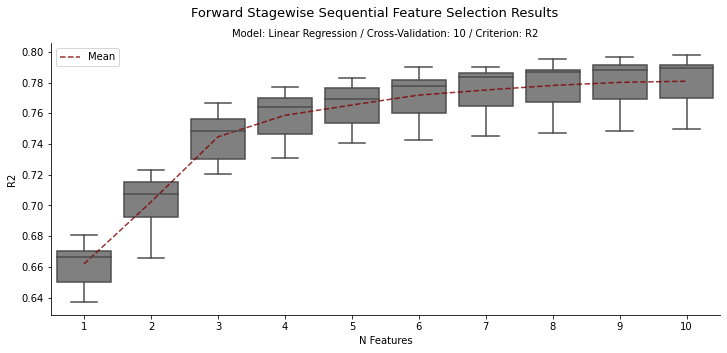

In [17]:
fig = plt.subplots(figsize=(12, 5))
p = sns.boxplot(x=tmp['n_feature'], y=tmp['score'], color='grey')
p1 = sns.lineplot(x=tmp_.index-1, y=tmp_.to_numpy().reshape(-1), color='maroon', 
                  linestyle='--', label='Mean', alpha=.8)
plt.title(r'Model: Linear Regression / Cross-Validation: 10 / Criterion: R2', fontsize=10)
plt.suptitle('Forward Stagewise Sequential Feature Selection Results', fontsize=13)
plt.xlabel('N Features')
plt.ylabel(r'R2')
sns.despine()
plt.show()

In [21]:
n_features = 4
best_feature_dict[n_features]

array(['max_median_freq_G', 'max_centroid_frequency2_M', 'max_imp_M',
       'max_centroid_frequency_S'], dtype=object)

In [22]:
X_best = X[best_feature_dict[n_features]]

In [23]:
results = cross_val_score(estimator=LinearRegression(), X=X_best, y=np.log(y), cv=10)
print('CV Results:\n', results)
print('Mean Resutls: ', np.mean(results))

CV Results:
 [0.74312963 0.77171474 0.73937037 0.75743827 0.77379263 0.7634382
 0.77720151 0.73118167 0.76424763 0.76521349]
Mean Resutls:  0.758672816167448
